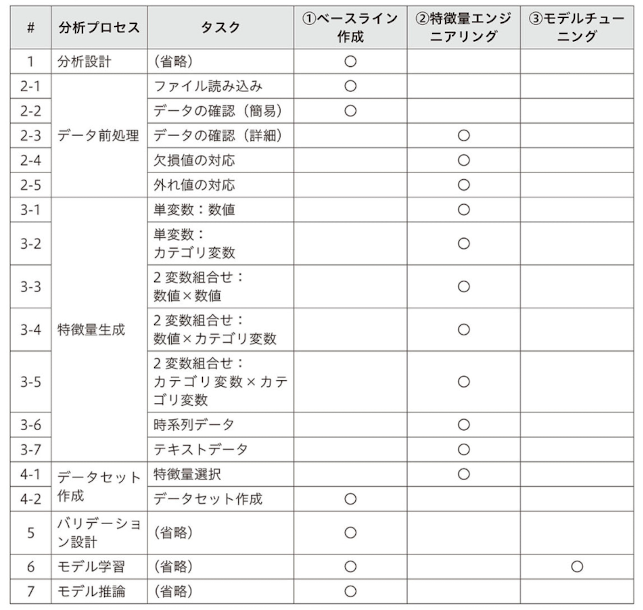

In [1]:
from IPython.display import Image, display
display(Image(filename="/kaggle/working/titanic/analytic_process.png"))

# ベースラインの作成

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import gc
import matplotlib.pyplot as plt # 可視化
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [3]:
# matplotlibで日本語表示したい場合はコレをinstall
! pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [4]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
print(df_train.shape)
print('レコード数：',len(df_train))
print('カラム数： ', len(df_train.columns))

(891, 12)
レコード数： 891
カラム数：  12


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### データ型の変換

In [7]:
print('-'*10, 'object型に変換', '-'*10)
df_train['Pclass'] = df_train['Pclass'].astype(object)
print(df_train[['Pclass']].info())

print('-'*10, 'もとの型に変換', '-'*10)
df_train['Pclass'] = df_train['Pclass'].astype(int)
print(df_train[['Pclass']].info())




---------- object型に変換 ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB
None
---------- もとの型に変換 ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB
None


#### 欠損値の確認

In [8]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### データセットの作成
目的変数と説明変数を作成

例）
目的変数：Survived
説明変数：Pclass, Fare(ともに欠損値がなく、数値データだから)



In [9]:
X_train, y_train, id_train = df_train[['Pclass', 'Fare']], df_train[['Survived']], df_train[['PassengerId']]

print(X_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


#### バリデーション設計
作成するモデルの精度を手元のデータで判断すること
#### ■ホールドアウト検証
-> trainデータを「学習データ」と「検証データ」に分割する
【メリット】
- モデル学習一回のみ

【デメリット】
- 学習に使わないデータが生じる
- 検証データの選び方によって評価値が偏る可能性がある

In [10]:
# va:validationの略
X_tr, X_va, y_tr, y_va = train_test_split(X_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train,
                                          random_state=42)

print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(f"y_train: {y_train['Survived'].mean():.3f}")
print(f"y_tr: {y_tr['Survived'].mean():.3f}")
print(f"y_va: {y_va['Survived'].mean():.3f}")

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train: 0.384
y_tr: 0.383
y_va: 0.385


#### ■ クロスバリデーション(交差検証)
-> trainデータから、複数の「学習データ」と「検証データ」の組を作成する
【メリット】
- すべてのデータを学習に利用できる
- 検証データの選び型による偏りを抑制できる
【デメリット】
- モデル学習を複数回行う必要がある

In [11]:
# 5fold クロスバリデーション
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X_train, y_train))
print(cv)

for nfold in np.arange(n_splits):
    print('-'*20, nfold, '-'*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(X_tr.shape, y_tr.shape)
    print(X_va.shape, y_va.shape)
    print(f"y_train: {y_train['Survived'].mean():.3f}")
    print(f"y_tr: {y_tr['Survived'].mean():.3f}")
    print(f"y_va: {y_va['Survived'].mean():.3f}")

[(array([  0,   1,   2,   3,   5,   7,   8,   9,  10,  11,  12,  14,  15,
        16,  17,  18,  20,  21,  22,  23,  25,  27,  29,  32,  33,  35,
        36,  37,  38,  39,  40,  41,  42,  44,  46,  47,  48,  49,  50,
        51,  52,  54,  56,  57,  58,  59,  61,  62,  65,  67,  69,  70,
        71,  72,  73,  74,  76,  77,  78,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  91,  92,  93,  95,  96,  97,  98, 100, 101,
       102, 104, 106, 107, 109, 110, 111, 112, 115, 116, 117, 119, 120,
       121, 122, 123, 124, 125, 127, 129, 130, 132, 133, 135, 136, 137,
       138, 139, 140, 142, 144, 145, 149, 151, 152, 154, 156, 157, 158,
       159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 171, 172, 175,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204,
       205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 

### モデル学習(勾配ブースティング)

#### ■ ホールドアウト検証を利用したモデル学習

In [12]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train,
                                          y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train,
                                          random_state=42)

print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(f"y_train: {y_train['Survived'].mean():.3f}")
print(f"y_tr: {y_tr['Survived'].mean():.3f}")
print(f"y_va: {y_va['Survived'].mean():.3f}")

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train: 0.384
y_tr: 0.383
y_va: 0.385


In [13]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

model = lgb.LGBMClassifier(**params)
# 昔の書き方
# model.fit(X_tr,
#           y_tr, 
#           eval_set=[(X_tr, y_tr), (X_va, y_va)], 
#           early_stopping_rounds=100,
#           verbose=10,
#           )

# 新しい書き方
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_tr, y_tr), (X_va, y_va)],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=10)
    ]
)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.802657	valid_1's auc: 0.674769
[20]	training's auc: 0.818577	valid_1's auc: 0.681423
[30]	training's auc: 0.827526	valid_1's auc: 0.674967
[40]	training's auc: 0.833988	valid_1's auc: 0.67859
[50]	training's auc: 0.838815	valid_1's auc: 0.678195
[60]	training's auc: 0.843075	valid_1's auc: 0.675099
[70]	training's auc: 0.84718	valid_1's auc: 0.674835
[80]	training's auc: 0.849058	valid_1's auc: 0.671673
[90]	training's auc: 0

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

In [14]:
from sklearn.metrics import accuracy_score

# モデルの精度評価
y_tr_pred = model.predict(X_tr)
y_va_pred = model.predict(X_va)

# metric = モデルの良し悪しを数値で測るもの
# accuracy = 正解率
metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)

print("正解率")
print(f"tr: {metric_tr:.3f}")
print(f"va: {metric_va:.3f}")




正解率
tr: 0.732
va: 0.659


In [15]:
# 重要な説明変数を算出
imp = pd.DataFrame({"col": X_train.columns, "imp": model.feature_importances_})
imp.sort_values(by="imp", ascending=False, ignore_index=True)

col         imp
0    Fare  779.066368
1  Pclass  276.019294

### ■ クロスバリデーションを利用したモデル学習

In [16]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

metrics = []
imp = pd.DataFrame()

n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X_train, y_train))

for nfold in np.arange(n_splits):
    print('-'*20, nfold, '-'*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]

    print(X_tr.shape, y_tr.shape)
    print(X_va.shape, y_va.shape)
    print(f"y_train: {y_train['Survived'].mean():.3f}")
    print(f"y_tr: {y_tr['Survived'].mean():.3f}")
    print(f"y_va: {y_va['Survived'].mean():.3f}")

    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)],
              callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=100)])
    
    y_tr_pred = model.predict(X_tr)
    y_va_pred = model.predict(X_va)

    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)

    print("正解率")
    print(f"tr: {metric_tr:.3f}")
    print(f"va: {metric_va:.3f}")

    metrics.append([nfold, metric_tr, metric_va])

    # _imp = pd.concat([imp, pd.DataFrame({"col": X_tr.columns, "imp": model.feature_importances_})], ignore_index=True)
    # imp = _imp
    _imp = pd.DataFrame({"col": X_tr.columns, "imp": model.feature_importances_, "nfold": nfold})
    imp = pd.concat([imp, _imp], ignore_index=True)

# print(imp)
print("-"*20, "モデル精度", "-"*20)
metrics = np.array(metrics)
print(metrics)

print(f"[cv {n_splits}回] tr: {metrics[:,1].mean():.3f}+-{metrics[:,1].std():.3f}")
print(f"[cv {n_splits}回] va: {metrics[:,2].mean():.3f}+-{metrics[:,2].std():.3f}")

imp = imp.groupby("col")["imp"].agg({"mean", "std"})
imp.columns = ["imp", "imp_std"]
imp = imp.reset_index(drop=False)

print("完了")
    

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train: 0.384
y_tr: 0.383
y_va: 0.385
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.829257	valid_1's auc: 0.778722
Early stopping, best iteration is:
[15]	training's auc: 0.785372	valid_1's auc: 0.78722
正解率
tr: 0.735
va: 0.709
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train: 0.384
y_tr: 0.384
y_va: 0.382
[LightGBM] [Info] Number of positive: 274, numb

In [17]:
# 説明変数の重要度
imp.sort_values(by="imp", ascending=False, ignore_index=True)

col         imp     imp_std
0    Fare  360.118500  948.028593
1  Pclass   54.770409  361.413778

## 特徴量エンジニアリング

In [18]:
# モデル学習・評価の関数化
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

def train_cv(input_x, input_y, input_id, params, n_splits=5):
    metrics = []
    imp = pd.DataFrame()

    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(input_x, input_y))
    for nfold in np.arange(n_splits):
        print('-'*20, nfold, '-'*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print(f"y_train: {input_y['Survived'].mean():.3f}")
        print(f"y_tr: {y_tr['Survived'].mean():.3f}")
        print(f"y_va: {y_va['Survived'].mean():.3f}")

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)],
                  callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=100)])
        
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)

        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)

        print("正解率")
        print(f"tr: {metric_tr:.3f}")
        print(f"va: {metric_va:.3f}")

        metrics.append([nfold, metric_tr, metric_va])
        
        
        
        _imp = pd.DataFrame({"col": x_tr.columns, "imp": model.feature_importances_, "nfold": nfold})
        imp = pd.concat([imp, _imp], ignore_index=True)

    print("完了")
    metrics = np.array(metrics)
    print(metrics)

    print("-"*20, "モデル精度(クロスバリデーション)", "-"*20)
    print(f"tr: {metrics[:,1].mean():.3f}+-{metrics[:,1].std():.3f}")
    print(f"va: {metrics[:,2].mean():.3f}+-{metrics[:,2].std():.3f}")

    imp = imp.groupby("col")["imp"].agg({"mean", "std"})
    imp.columns = ['imp', 'imp_std']
    imp = imp.reset_index(drop=False)

    print("終了")
    return imp, metrics


In [19]:
imp, metrics = train_cv(X_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train: 0.384
y_tr: 0.383
y_va: 0.385
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.829257	valid_1's auc: 0.778722
Early stopping, best iteration is:
[15]	training's auc: 0.785372	valid_1's auc: 0.78722
正解率
tr: 0.735
va: 0.709
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train: 0.384
y_tr: 0.384
y_va: 0.382
[LightGBM] [Info] Number of positive: 274, numb

In [20]:
# 変数追加 -> データセット作成
X_train, y_train, id_train = df_train[["Pclass", "Fare", "Age"]], df_train[["Survived"]], df_train[["PassengerId"]]
print(X_train.shape, y_train.shape, id_train.shape)

(891, 3) (891, 1) (891, 1)


In [21]:
imp, metrics = train_cv(X_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 3) (712, 1)
(179, 3) (179, 1)
y_train: 0.384
y_tr: 0.383
y_va: 0.385
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915225	valid_1's auc: 0.82253
Early stopping, best iteration is:
[93]	training's auc: 0.911637	valid_1's auc: 0.825165
正解率
tr: 0.823
va: 0.687
-------------------- 1 --------------------
(713, 3) (713, 1)
(178, 3) (178, 1)
y_train: 0.384
y_tr: 0.384
y_va: 0.382
[LightGBM] [Info] Number of positive: 274, numb

In [22]:
imp.sort_values(by="imp", ascending=False, ignore_index=True)

col         imp     imp_std
0    Fare  267.292068  843.476844
1     Age  191.415814  755.901324
2  Pclass   73.032744  392.502835

### データ前処理

In [23]:
# 数値データ
df_train.describe().T

count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

In [24]:
# カテゴリ変数
df_train.describe(exclude="number").T

count unique                      top freq
Name       891    891  Braund, Mr. Owen Harris    1
Sex        891      2                     male  577
Ticket     891    681                   347082    7
Cabin      204    147                  B96 B98    4
Embarked   889      3                        S  644

In [25]:
# agg:aggregation(集計)の略
df_train[["Fare"]].agg(["mean"]).T

mean
Fare  32.204208

In [26]:
df_train[["Fare"]].agg(["mean", "std", "min", "max"]).T

mean        std  min       max
Fare  32.204208  49.693429  0.0  512.3292

In [27]:
df_train[["Fare"]].agg(["dtype", "count", "nunique"]).T

dtype count nunique
Fare  float64   891     248

In [28]:
df_train['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [29]:
# 昔のやり方
# import pandas_profiling as pdp
# pdp.ProfileReport(df_train)


from ydata_profiling import ProfileReport
report = ProfileReport(df_train)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 欠損値の把握と保管

In [30]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

欠損値を埋める

In [31]:
# 0で埋める
df_train['Age_fillna_0'] = df_train['Age'].fillna(0)
df_train.loc[df_train['Age'].isnull(), ["Age", "Age_fillna_0"]].head()

Age  Age_fillna_0
5   NaN           0.0
17  NaN           0.0
19  NaN           0.0
26  NaN           0.0
28  NaN           0.0

In [32]:
# 平均値
df_train["Age_fillna_mean"] = df_train["Age"].fillna(df_train['Age'].mean())
df_train.loc[df_train['Age'].isnull(), ['Age', 'Age_fillna_mean']].head()

Age  Age_fillna_mean
5   NaN        29.699118
17  NaN        29.699118
19  NaN        29.699118
26  NaN        29.699118
28  NaN        29.699118

カテゴリ変数の場合

In [33]:
# 空文字で埋める
df_train['Cabin_fillna_space'] = df_train['Cabin'].fillna('')
df_train.loc[df_train['Cabin'].isnull(), ['Cabin', 'Cabin_fillna_space']].head()

Cabin Cabin_fillna_space
0   NaN                   
2   NaN                   
4   NaN                   
5   NaN                   
7   NaN

In [34]:
df_train['Cabin_fillna_mode'] = df_train['Cabin'].fillna(df_train["Cabin"].mode()[0])
df_train.loc[df_train['Cabin'].isnull(), ["Cabin", "Cabin_fillna_mode"]].head()

Cabin Cabin_fillna_mode
0   NaN           B96 B98
2   NaN           B96 B98
4   NaN           B96 B98
5   NaN           B96 B98
7   NaN           B96 B98

#### 外れ値の検出

In [35]:
# 最小値と最大値の確認
df_train["Age"].agg(["min", "max"])

min     0.42
max    80.00
Name: Age, dtype: float64

<Axes: >

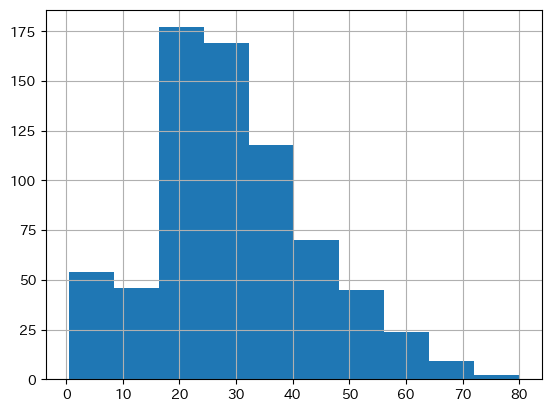

In [36]:
# ヒストグラムで確認
df_train["Age"].hist()

In [37]:
# 四分位数範囲で確認
quartile = df_train["Age"].quantile(q=0.75) - df_train["Age"].quantile(q=0.25)

print('四分位数範囲:', quartile)
print('下限値：', df_train["Age"].quantile(q=0.25) - quartile * 1.5)
print('上限値：', df_train["Age"].quantile(q=0.75) + quartile * 1.5)

四分位数範囲: 17.875
下限値： -6.6875
上限値： 64.8125


上記で得られた「上限値」と「下限値」を超えたら外れ値

In [38]:
# 外れ値を欠損値に変換
df_train.loc[df_train["Age"]< 0, "Age"] = np.nan

### 標準化・正規化
標準化：平均0、標準偏差1に変換（各値から平均値を引いて、標準偏差で割る）

正規化：最小値0、最大値1に変換（各値から最小値を引いて、最大値と最小値の差分で割る）

- 上記の工程を経ることで、データの「大きさ」が統一される
- この処理が必要かどうかはモデルによる
  - 標準化：重回帰モデルやK近傍法などで標準化が必要
  - 正規化（または標準化）：NN・DL
  - 不要：決定木系（LightGBMなど）



In [39]:
# 標準化
value_mean = df_train["Fare"].mean()
value_std = df_train["Fare"].std(ddof=0) # 母集団の標準偏差を利用する場合
# value_std = df_train["Fare"].std() # 標本の標準偏差を利用する場合
print('mean: ', value_mean, ', std: ', value_std)

df_train["Fare_standardized"] = (df_train["Fare"] - value_mean) / value_std
df_train[["Fare", "Fare_standardized"]].head()

mean:  32.204207968574636 , std:  49.66553444477411


Fare  Fare_standardized
0   7.2500          -0.502445
1  71.2833           0.786845
2   7.9250          -0.488854
3  53.1000           0.420730
4   8.0500          -0.486337

In [40]:
# sklearnを使用した標準化
std = StandardScaler()
std.fit(df_train[["Fare"]])
print('mean: ', std.mean_[0], ', std: ', np.sqrt(std.var_[0]))

df_train['Fare_standard'] = std.transform(df_train[["Fare"]])
df_train[["Fare", "Fare_standard"]].head()

mean:  32.204207968574636 , std:  49.6655344447741


Fare  Fare_standard
0   7.2500      -0.502445
1  71.2833       0.786845
2   7.9250      -0.488854
3  53.1000       0.420730
4   8.0500      -0.486337

In [41]:
# 正規化
value_min = df_train['Fare'].min()
value_max = df_train['Fare'].max()
print('min: ', value_min, ', max: ', value_max)

df_train['Fare_normalized'] = (df_train['Fare'] - value_min) / (value_max - value_min)
df_train[["Fare", "Fare_normalized"]].head()

min:  0.0 , max:  512.3292


Fare  Fare_normalized
0   7.2500         0.014151
1  71.2833         0.139136
2   7.9250         0.015469
3  53.1000         0.103644
4   8.0500         0.015713

In [42]:
# sklearnを使用した正規化
mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(df_train[["Fare"]])
print('min: ', mms.data_min_[0], ', max: ', mms.data_max_[0])

df_train['Fare_normalized'] = mms.transform(df_train[["Fare"]])
df_train[["Fare", "Fare_normalized"]].head()

min:  0.0 , max:  512.3292


Fare  Fare_normalized
0   7.2500         0.014151
1  71.2833         0.139136
2   7.9250         0.015469
3  53.1000         0.103644
4   8.0500         0.015713

### 特徴量生成

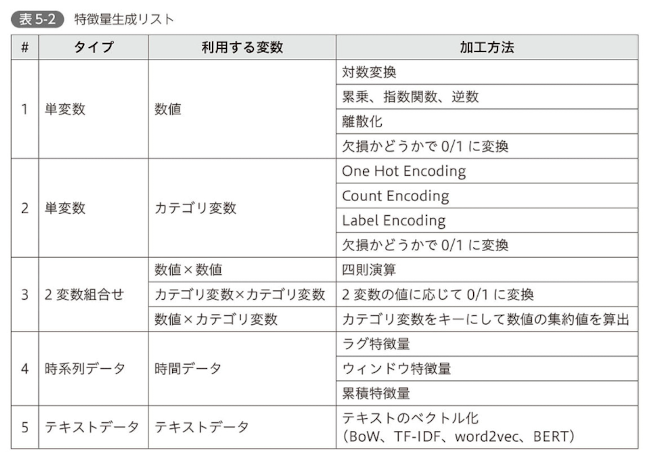

In [43]:
from IPython.display import Image, display
display(Image(filename="/kaggle/working/titanic/features.png"))

単変数（数値）

In [44]:
# 対数変換
df_train['Fare_log'] = np.log(df_train['Fare'] + 1e-5)
df_train[['Fare', 'Fare_log']].head()

Fare  Fare_log
0   7.2500  1.981003
1  71.2833  4.266662
2   7.9250  2.070024
3  53.1000  3.972177
4   8.0500  2.085673

In [45]:
# 累乗・指数関数・逆数
df_train['Fare_square'] = df_train['Fare'].apply(lambda x: x**2)
df_train['Fare_exp'] = df_train['Fare'].apply(lambda x: np.exp(x))
df_train['Fare_reciprocal'] = df_train['Fare'].apply(lambda x: 1/(x+1e-3))
df_train[['Fare', 'Fare_square', 'Fare_exp', 'Fare_reciprocal']].head()


Fare  Fare_square      Fare_exp  Fare_reciprocal
0   7.2500    52.562500  1.408105e+03         0.137912
1  71.2833  5081.308859  9.077031e+30         0.014028
2   7.9250    62.805625  2.765564e+03         0.126167
3  53.1000  2819.610000  1.150898e+23         0.018832
4   8.0500    64.802500  3.133795e+03         0.124208

In [46]:
# 離散化
# ビンと呼ばれる区間を決めて、数値をビンに変換する
df_train['Age_bin'] = pd.cut(df_train['Age'],
                             bins=[0, 10, 20, 30, 40, 50, 100], # 分割したい区間（個数 or 境界値のリスト）
                             right=False, 
                             labels=["10歳未満", "10代", "20代", "30代", "40代", "50代以上"],
                             duplicates='raise',
                             include_lowest=True, # 最小値を最初の区間に含めるか
                             )
df_train['Age_bin'] = df_train['Age_bin'].astype(str)
df_train[['Age', 'Age_bin']].head()


Age Age_bin
0  22.0     20代
1  38.0     30代
2  26.0     20代
3  35.0     30代
4  35.0     30代

In [47]:
# 欠損かどうかで 0/1 に変換
# df_train['Age'].isnull() -> booleanで返る
# df_train['test'] = df_train['Age'].isnull().astype(int) 下と同じ
df_train['Age_na'] = df_train['Age'].isnull()*1
df_train[['Age', 'Age_na']].head(7)

Age  Age_na
0  22.0       0
1  38.0       0
2  26.0       0
3  35.0       0
4  35.0       0
5   NaN       1
6  54.0       0

単変数（カテゴリ）

One Hot Encoding

In [48]:
ohe_embarked = OneHotEncoder(sparse=False)
ohe_embarked.fit(df_train[['Embarked']]) # カテゴリ情報を学習

tmp_embarked = pd.DataFrame(
    ohe_embarked.transform(df_train[['Embarked']]), # カテゴリ情報を変換
    columns=[f"Embarked_{i}" for i in ohe_embarked.categories_[0]] # カテゴリ情報を列名に変換
)

df_train = pd.concat([df_train, tmp_embarked], axis=1)
df_train[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_nan']].head()

Embarked  Embarked_C  Embarked_Q  Embarked_S  Embarked_nan
0        S         0.0         0.0         1.0           0.0
1        C         1.0         0.0         0.0           0.0
2        S         0.0         0.0         1.0           0.0
3        S         0.0         0.0         1.0           0.0
4        S         0.0         0.0         1.0           0.0

In [49]:
# 一括変換：複数のカテゴリ変数をまとめて、One Hot Encoding
df_ohe = pd.get_dummies(df_train[['Embarked', 'Sex']], dummy_na=True, drop_first=False)
df_ohe.head()

Embarked_C  Embarked_Q  Embarked_S  Embarked_nan  Sex_female  Sex_male  \
0       False       False        True         False       False      True   
1        True       False       False         False        True     False   
2       False       False        True         False        True     False   
3       False       False        True         False        True     False   
4       False       False        True         False       False      True   

   Sex_nan  
0    False  
1    False  
2    False  
3    False  
4    False

Count Encoding
- 出現回数を変数とする

In [50]:
ce_Embarked = df_train['Embarked'].value_counts().to_dict()
print(ce_Embarked)
df_train['Embarked_ce'] = df_train['Embarked'].map(ce_Embarked)
df_train[['Embarked', 'Embarked_ce']].head()

{'S': 644, 'C': 168, 'Q': 77}


Embarked  Embarked_ce
0        S        644.0
1        C        168.0
2        S        644.0
3        S        644.0
4        S        644.0

## Label Encoding
- カテゴリ変数を数値に変換



In [51]:
le_embarked = LabelEncoder()
le_embarked.fit(df_train['Embarked'])
df_train['Embarked_le'] = le_embarked.transform(df_train['Embarked'])
df_train[['Embarked', 'Embarked_le']].head()

Embarked  Embarked_le
0        S            2
1        C            0
2        S            2
3        S            2
4        S            2

欠損値かどうかで0/1に変換

In [52]:
df_train['Embarked_na'] = df_train['Embarked'].isnull()*1
df_train.loc[df_train['Embarked'].isnull(), ['Embarked', 'Embarked_na']].head()

Embarked  Embarked_na
61       NaN            1
829      NaN            1

### ２変数組み合わせ: 数値 X 数値

数値 X 数値


In [53]:
df_train['SibSp_+_Parch'] = df_train['SibSp'] + df_train['Parch']
df_train[['SibSp', 'Parch', 'SibSp_+_Parch']].head()


SibSp  Parch  SibSp_+_Parch
0      1      0              1
1      1      0              1
2      0      0              0
3      1      0              1
4      0      0              0

数値 X カテゴリ

In [54]:
df_agg = df_train.groupby('Sex')['Fare'].agg(['mean']).reset_index()
df_agg.columns = ['Sex', 'mean_Fare_by_Sex']

print('集約テーブル')

display(df_agg)

df_train = pd.merge(df_train, df_agg, on='Sex', how='left')
print('結合後テーブル')
display(df_train[['Sex', 'Fare', 'mean_Fare_by_Sex']].head())

集約テーブル


Sex  mean_Fare_by_Sex
0  female         44.479818
1    male         25.523893

結合後テーブル


Sex     Fare  mean_Fare_by_Sex
0    male   7.2500         25.523893
1  female  71.2833         44.479818
2  female   7.9250         44.479818
3  female  53.1000         44.479818
4    male   8.0500         25.523893

In [56]:
# 集約テーブルを作成しない場合
df_train['mean_Fare_by_Sex'] = df_train.groupby('Sex')['Fare'].transform('mean')
df_train[['Sex', 'Fare', 'mean_Fare_by_Sex']].head()

Sex     Fare  mean_Fare_by_Sex
0    male   7.2500         25.523893
1  female  71.2833         44.479818
2  female   7.9250         44.479818
3  female  53.1000         44.479818
4    male   8.0500         25.523893

カテゴリ変数 X カテゴリ変数

In [ ]:
# 出現回数
df_tbl = pd.crosstab(df_train['Sex'], df_train['Embarked'])
print('集約テーブル（クロス集計）')
display(df_tbl)